# We have the problem that wind forcing seems to dominate changes to modal decomposition, rather than topo shape!

## In this notebook, compare the same time slices over 100hr average. Focus on mode 1. Make movies maybe?

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

<Client: 'tcp://127.0.0.1:36399' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36399,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:35855,Total threads: 4
Dashboard: /proxy/33659/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34683,


## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [3]:
trange = 50
to_process = {
    "full-20": {
        "data":tt.collect_data(
            exptname="full-20",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
        },
    "blank-20": {
        "data":tt.collect_data(
            exptname="blank-20",
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange)
        ).sel(yb = slice(-50,50))
    },
    "ideal-20": {
        "data":tt.collect_data(
            exptname="ideal-20",
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange)
        ).sel(yb = slice(-50,50)),
    },
    "smooth-20": {
        "data":tt.collect_data(
            exptname="smooth-20",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()
        },
    }

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/118726826.gadi-pbs/ipykernel_2116013/1335473955.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()


loading rho...	done.
loading u...	done.
loading v...	done.
loading rho...	done.
loading u...	done.
loading v...	done.
Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/118726826.gadi-pbs/ipykernel_2116013/1335473955.py:29: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).sel(yb = slice(-50,50)).drop("cst").chunk({"zl":-1,"time":10}).persist()


In [2]:
## Redefine vertical modes. Expect data to include u and v.

def VerticalModes(data,zrange = slice(None,None),nmodes = 5):
    """
    Use approximate Sturm-Liouville theory to calculate the vertical modes of the data. You can feed it 4D (xyzt). or 3D (xyz) data,
    if 4D it will return a timeseries of the horizontal coefficients. Currently only does horizontal velocities! Will add vertical later.
    
    input:
    data : xarray.Dataset
        dataset needs to contain u,v,rho and H. H is ocean depth, and must be positive down. Time dimension must be "time" and vertical dimension must be "zl"
    var : str

    returns:
        Dataset with u(nxyt),v(nxyt) and phi(nxyz) where phi is the eigenfunction of the vertical mode
    
    """
    data["H"] = np.abs(data.bathy)
    if "time" in data.rho.dims:
        data["N"] = tt.calculate_N(data.rho).rename("N").mean("time")
    else:
        data["N"] = tt.calculate_N(data.rho).rename("N")

    # data["N"] = np.linspace(data.N[0],data.N[-1],len(data["N"]))
    zl = data.zl.values
    ## Later we need to do a cumulative integral along the z axis. This is a pain in xarray, so we'll use scipy and pass this to xarray's 'apply_along_axis' method. 
    def scipy_integrate(data):
        # print(data)
        return (data * 0) + scipy.integrate.cumulative_trapezoid(
            data,
            x = zl,
            initial = 0
            )


    # Use np.apply_along_axis to prevent averaging over N and H!
    eigenvectors = (data["rho"].isel(time = 0) * 0).expand_dims({"mode":nmodes})

    ## Construct empty arrays of the right dimensions to store the output
    uout = (data["rho"].isel(zl = 0) * 0).expand_dims({"mode":nmodes})
    vout = (data["rho"].isel(zl = 0) * 0).expand_dims({"mode":nmodes}) 
    Nbar = data.N.integrate("zl") / data.H

    for n in range(1,nmodes + 1): ## Start from 1 or else your first eigenfunction only depends on N!
        
        to_integrate = (n * data["N"] * np.pi) / (data.H * Nbar) ## This is the bit in the Approx Sturm-Liouville eqn under the integral sign within the cos term
        # This next line is a convuluted (but computationally efficient!) way of doing the cumulative sum along the z axis.
        integrated =  np.apply_along_axis(scipy_integrate,to_integrate.get_axis_num('zl'),to_integrate) 

        # This is just the rest of the eigenfunction. Fill NANs with 0s so that integrating over bathymetry doesn't cause problems.
        phi_n = (np.sqrt(
            2 * data.N / (data.H * Nbar)
        ) * np.cos(
            integrated
        )).fillna(0)

        eigenvectors[n-1,:,:,:] = phi_n
        # Handle the 3D or 3D data inputs.
        if "time" in data.u.dims:
            uout[n - 1,:,:,:] = (data.u.fillna(0) * phi_n).sel(zl = zrange).integrate("zl")
            vout[n - 1,:,:,:] = (data.v.fillna(0) * phi_n).sel(zl = zrange).integrate("zl")
        else:
            uout[n - 1,:,:] = (data.u.fillna(0) * phi_n).sel(zl = zrange).integrate("zl")
            vout[n - 1,:,:] = (data.v.fillna(0) * phi_n).sel(zl = zrange).integrate("zl")

    return xr.merge([uout.rename("u"),vout.rename("v"),eigenvectors.rename("phi")])

# vmodes = VerticalModes(to_process["full-20"]["data"]).load()

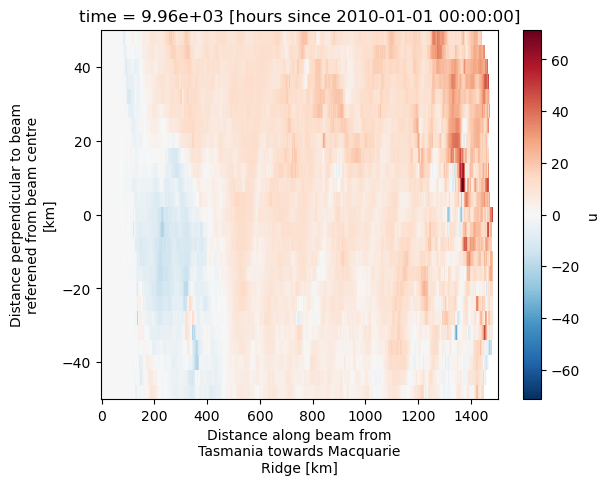

In [16]:
to_process["full-20"]["data"]["u"].isel(time = 10).integrate("zl").plot()

In [12]:
for expt in to_process:
    print(expt)
    u = tt.VerticalModes(to_process[expt]["data"],"u").hztl
    v = tt.VerticalModes(to_process[expt]["data"],"v").hztl

    ## Now calculate the KE and integrate in time
    KE = 0.5 * ((u**2 + v**2)).mean("time").integrate("yb")
    to_process[expt]["KE"] = KE.load()


full-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


blank-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


ideal-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


smooth-20


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 64.98 MiB.
This may cause some slowd

Text(0.5, 0, '<-- Tassie  (km)  Macquarie Ridge -->')

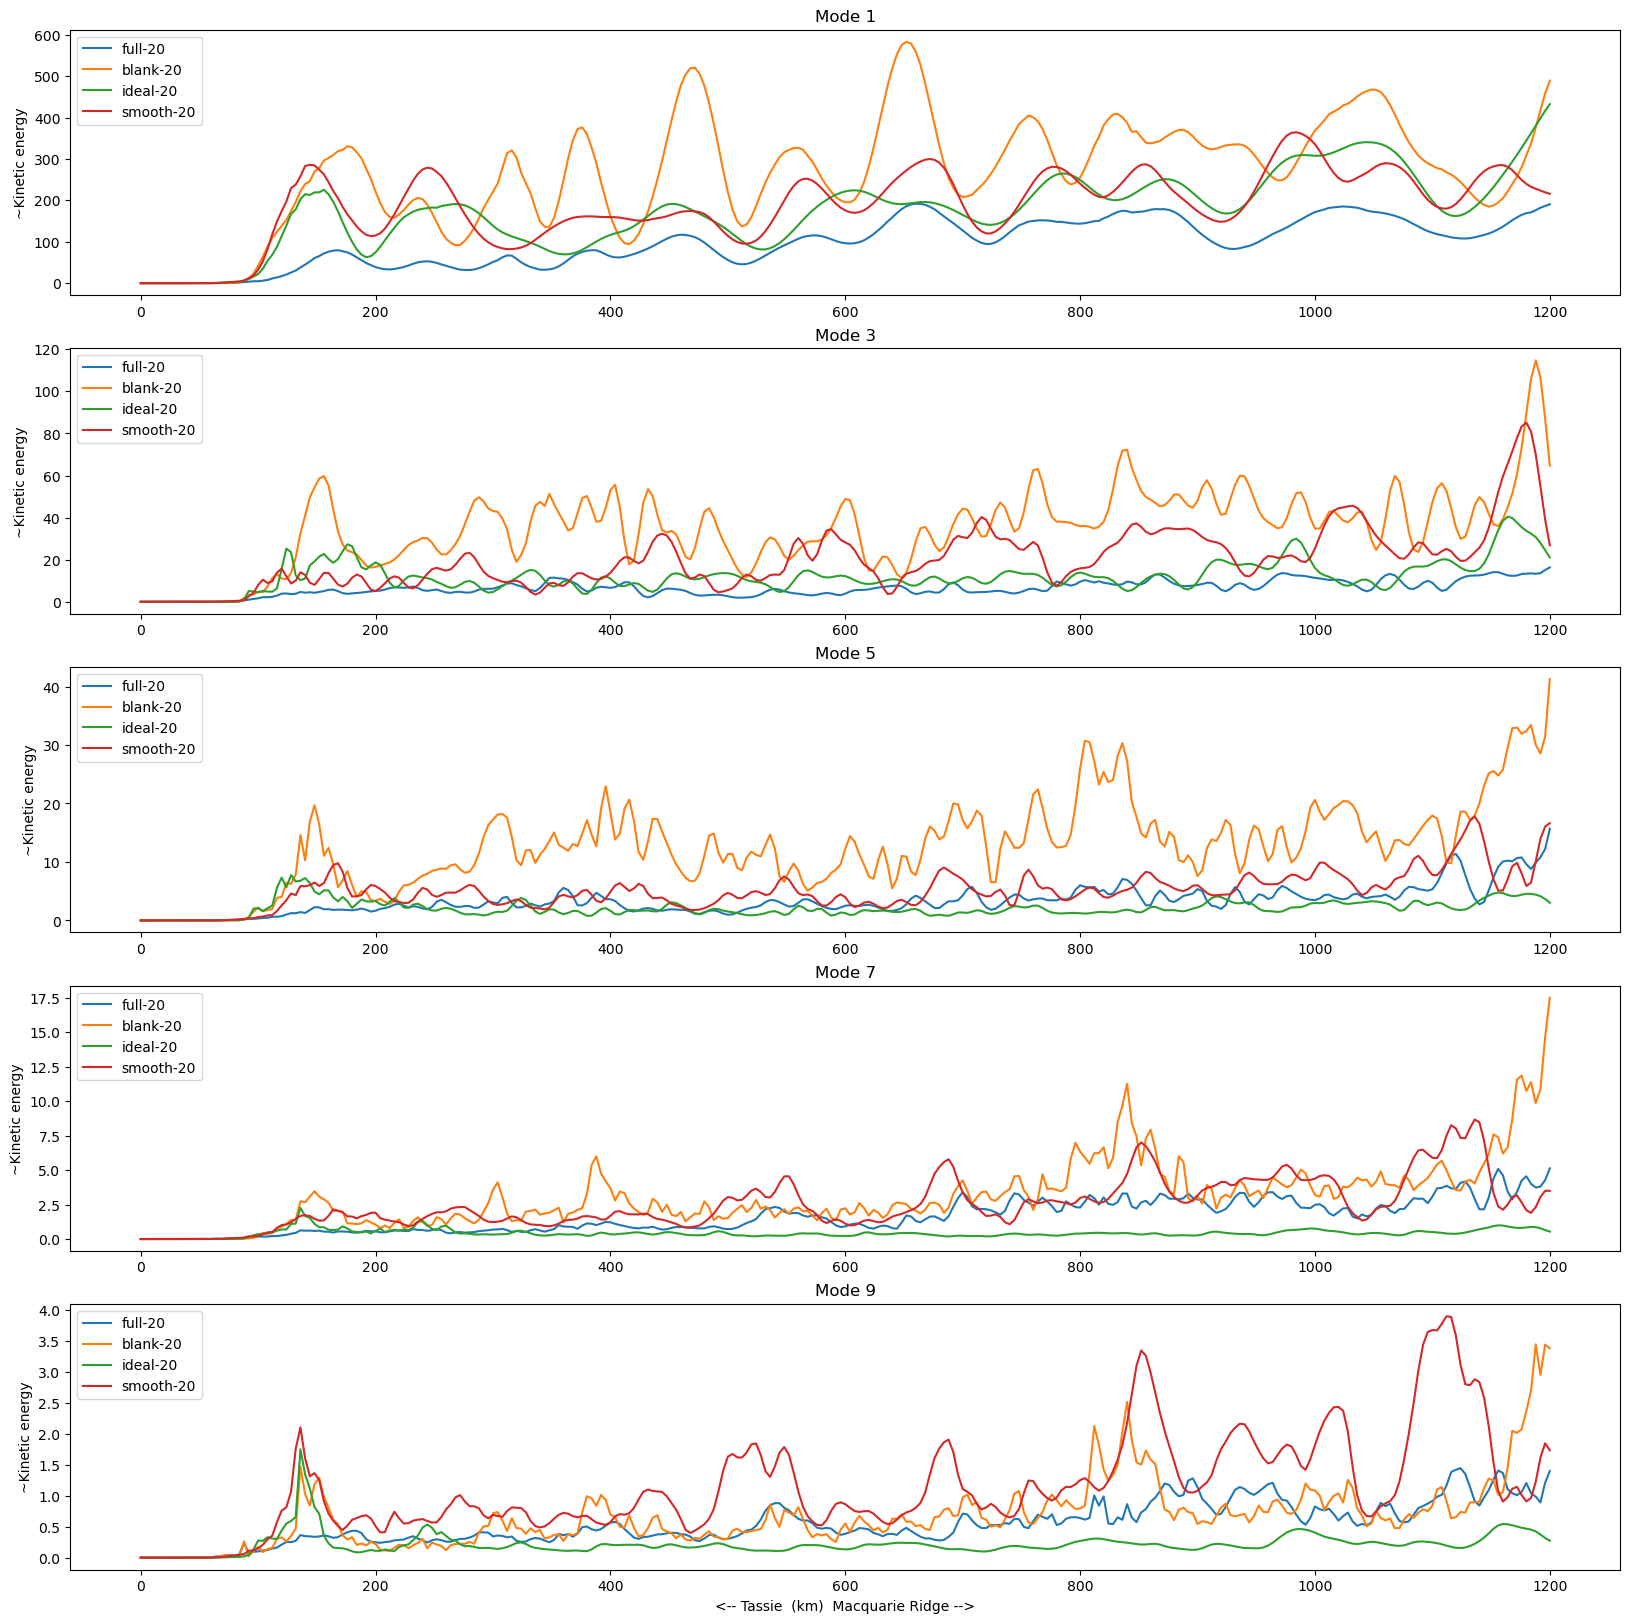

In [19]:
fig,ax = plt.subplots(5,figsize = (20,20))

for expt in to_process:
    for i,mode in enumerate(range(1,10,2)):
        to_process[expt]["KE"].mean("time").integrate("yb").isel(mode = mode).sel(xb = slice(0,1200)).plot(ax = ax[i],label = expt)

        ax[i].set_title(f"Mode {mode}")


        ax[i].legend()
        ax[i].set_ylabel("~Kinetic energy")
        ax[i].set_xlabel("")



ax[-1].set_xlabel("<-- Tassie  (km)  Macquarie Ridge -->")


In [17]:
for expt in to_process:
    print(expt)
    u = tt.VerticalModes(to_process[expt]["data"],"u").hztl
    v = tt.VerticalModes(to_process[expt]["data"],"v").hztl

    ## Now calculate the KE and integrate in time
    KE = 0.5 * ((u**2 + v**2))
    to_process[expt]["KE"] = KE


full-20
blank-20
ideal-20
smooth-20


# Vertical Mode Movie



In [ ]:
vmodes = VerticalModes(to_process["full-20"]["data"]).load()


In [4]:
def PlotForMovie(data):
    fig,ax = plt.subplots(5,2,figsize = (20,20))

    for i in range(len(data.mode)):

        data["u"].isel(mode = i).sel(xb = slice(0,1200)).plot(ax = ax[i,0])
        data["v"].isel(mode = i).sel(xb = slice(0,1200)).plot(ax = ax[i,1])
        tt.plot_topo(ax[i,0])
        tt.plot_topo(ax[i,1])
        ax[i,0].set_xlim(0,1200)
        ax[i,1].set_xlim(0,1200)
        ax[i,0].set_title("")
        ax[i,1].set_title("")
        ax[i,0].set_xlabel("")
        ax[i,1].set_ylabel("Mode: " + str(i + 1))
        ax[i,1].set_xlabel("")
        ax[i,0].set_ylabel("Distance to beam centre (km)")

    ax[-1,0].set_xlabel("Distance from Tas (km)")
    ax[-1,1].set_xlabel("Distance from Tas (km)")
        
    return fig

# fig = PlotForMovie(vmodes.isel(time = 50))

# tt.make_movie(
#     vmodes,
#     PlotForMovie,
#     "full-20",
#     "vertical_modes"
# )


In [5]:
# for d in ["full-20","smooth-20"]:
for d in ["smooth-20"]:
    data = tt.collect_data(
            exptname=d,
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).drop("cst").chunk({"zl":-1}).sel(xb = slice(0,1200)).persist()
    tt.make_movie(
        VerticalModes(data).load(),
        PlotForMovie,
        d,
        "vertical_modes_fulldomain"
    )

    

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/118778567.gadi-pbs/ipykernel_1919365/479221704.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).drop("cst").chunk({"zl":-1}).sel(xb = slice(0,1200)).persist()
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data

2024-06-21 10:06:57,576 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-u-856d072b98cb891f58f5f62fa3ea6bf6' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x151dc537add0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x151cdcb423c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x151dc537add0>, (ImplicitToExplicitIndexingAdapte

Making movie vertical_modes_fulldomain for smooth-20
/g/data/v45/ab8992/movies_tmp/tasman-tides/smooth-20/movies/vertical_modes_fulldomain
ffmpeg -r 5  -i /g/data/v45/ab8992/movies_tmp/tasman-tides/smooth-20/movies/vertical_modes_fulldomain/frame_%05d.png -s 1920x1080 -c:v libx264 -pix_fmt yuv420p /g/data/v45/ab8992/dropbox/tasman-tides/smooth-20/moviesvertical_modes_fulldomain.mp4
ffmpeg finished with returncode 0 

 and output 


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmp

In [ ]:
trange = 50

for d in ["blank-20","ideal-20"]:
    data = tt.collect_data(
            exptname=d,
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange).chunk({"zl":-1,"time":10}).sel(xb = slice(0,1200)).persist()
    )
    tt.make_movie(
        VerticalModes(data).load(),
        PlotForMovie,
        d,
        "vertical_modes_fulldomain"
    )
